1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


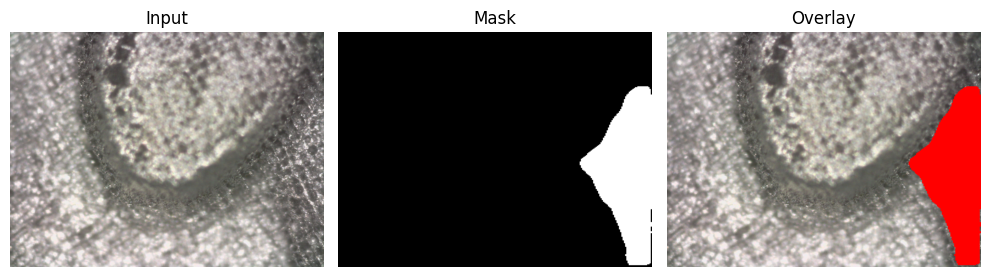

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

# -----------------------------
# 1) Either load the full saved model
#    (requires custom loss/metric definitions)
# -----------------------------
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2.*intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

# custom metric factory for MeanIoU
def mean_iou(y_true, y_pred):
    return tf.keras.metrics.MeanIoU(num_classes=2)(y_true, tf.cast(y_pred>0.5, tf.int32))

# Path to your .keras model
MODEL_PATH = "resattunet_final.keras"

model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects={
        "bce_dice_loss": bce_dice_loss,
        "dice_loss": dice_loss,
        "mean_iou":    tf.keras.metrics.MeanIoU  # keras will instantiate internally
    }
)

# -----------------------------
# 2) Or rebuild architecture + load weights only
#    (no need for custom_objects here if you only saved weights)
# -----------------------------
# from your previous code:
# model = build_res_attention_unet((256,256,3))
# WEIGHTS_PATH = "resattunet_weights.h5"
# model.load_weights(WEIGHTS_PATH)

# -----------------------------
# 3) Inference helper
# -----------------------------
def infer_and_plot(model, image_path, 
                   img_size=(256,256), threshold=0.5):
    # 1) Load original & keep copy for display
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h0, w0 = img_rgb.shape[:2]
    
    # 2) Resize & normalize
    img_resized = cv2.resize(img_rgb, img_size)
    inp = img_resized.astype(np.float32) / 255.0
    inp = np.expand_dims(inp, axis=0)  # batch dim
    
    # 3) Predict mask
    pred = model.predict(inp)[0, ..., 0]
    
    # 4) Threshold & resize mask back to original
    mask = (pred >= threshold).astype(np.uint8) * 255
    mask = cv2.resize(mask, (w0, h0), interpolation=cv2.INTER_NEAREST)
    
    # 5) Plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.imshow(img_rgb); plt.title("Input"); plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(mask, cmap="gray"); plt.title("Mask"); plt.axis("off")
    plt.subplot(1,3,3)
    # overlay mask on image
    overlay = img_rgb.copy()
    overlay[mask==255] = [255, 0, 0]  # red overlay
    plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 4) Run on your own images
# -----------------------------
test_images = ["D:\\IITG\\DATASET\\leaf\\127.jpg"]
  # replace with your paths
for img_path in test_images:
    infer_and_plot(model, img_path)


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

# -----------------------------
# 1) Custom losses and metrics
# -----------------------------
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2.*intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

def mean_iou(y_true, y_pred):
    return tf.keras.metrics.MeanIoU(num_classes=2)(y_true, tf.cast(y_pred > 0.5, tf.int32))

# -----------------------------
# 2) Load your model
# -----------------------------
MODEL_PATH = "resattunet_final.keras"

model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects={
        "bce_dice_loss": bce_dice_loss,
        "dice_loss": dice_loss,
        "mean_iou": tf.keras.metrics.MeanIoU
    }
)

# -----------------------------
# 3) Inference + Visualization
# -----------------------------
def infer_and_plot(model, image_path, img_size=(256, 256), threshold=0.5):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"Error: Failed to load image at {image_path}")
        return
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h0, w0 = img_rgb.shape[:2]

    img_resized = cv2.resize(img_rgb, img_size)
    inp = img_resized.astype(np.float32) / 255.0
    inp = np.expand_dims(inp, axis=0)

    pred = model.predict(inp)[0, ..., 0]

    mask = (pred >= threshold).astype(np.uint8) * 255
    mask = cv2.resize(mask, (w0, h0), interpolation=cv2.INTER_NEAREST)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title("Input")
    plt.axis("on")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Mask (Threshold={threshold:.2f})")
    plt.axis("on")

    plt.subplot(1, 3, 3)
    overlay = img_rgb.copy()
    overlay[mask == 255] = [255, 0, 0]
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("on")

    plt.tight_layout()
    plt.show()

# -----------------------------
# 4) Test images and THRESHOLD
# -----------------------------
test_images = ["D:\\IITG\\DATASET\\Machined\\side 2\\11.jpg"]  # <- replace with your own
THRESHOLD = 0.10  # <-- Change this to whatever you want (e.g. 0.3, 0.7)

for img_path in test_images:
    infer_and_plot(model, img_path, threshold=THRESHOLD)
